In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random
import pandas as pd
import seaborn as sns
import re


train_dir = '../../T_DEV_810/dataset/train'
val_dir = '../../T_DEV_810/dataset/val'
test_dir = '../../T_DEV_810/dataset/test'

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

Found 4900 images belonging to 2 classes.
Found 1050 images belonging to 2 classes.
Found 1050 images belonging to 2 classes.


In [12]:
def create_vgg16_model():
    conv_base = VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(150, 150, 3))
    
    for layer in conv_base.layers[:-4]:
        layer.trainable = False
    
    model = models.Sequential([
        conv_base,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=['accuracy'])
    return model

In [13]:
def plot_learning_curves(history, model_name):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{model_name} - Précision')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{model_name} - Perte')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_learning_curves.png')
    plt.show()

In [14]:
def get_pneumonia_type(filename):
    if "bacteria" in filename.lower():
        return "PNEUMONIA_BACTERIAL"
    elif "virus" in filename.lower():
        return "PNEUMONIA_VIRAL"
    else:
        return "PNEUMONIA_UNKNOWN"

def plot_binary_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred > 0.5)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['NORMAL', 'PNEUMONIA'], 
                yticklabels=['NORMAL', 'PNEUMONIA'])
    plt.xlabel('Prédiction')
    plt.ylabel('Vérité')
    plt.title(f'Matrice de confusion - {model_name}')
    plt.tight_layout()
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()
    
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    
    print(f"Métriques - {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity/Recall: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1_score:.4f}")
    
    return {'accuracy': accuracy, 'sensitivity': sensitivity, 
            'specificity': specificity, 'precision': precision, 'f1_score': f1_score}


In [15]:
def plot_roc_curve(y_true, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title(f'Courbe ROC - {model_name}')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(f'{model_name}_roc_curve.png')
    plt.show()
    
    return roc_auc

In [16]:
def analyze_pneumonia_predictions(model, test_dir):
    results = {
        "NORMAL": {"correct": 0, "total": 0},
        "PNEUMONIA_BACTERIAL": {"correct": 0, "total": 0, "predicted_as_normal": 0},
        "PNEUMONIA_VIRAL": {"correct": 0, "total": 0, "predicted_as_normal": 0}
    }
    
    all_predictions = []
    
    normal_dir = os.path.join(test_dir, "NORMAL")
    if os.path.exists(normal_dir):
        for filename in os.listdir(normal_dir):
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(normal_dir, filename)
                
                img = load_img(image_path, target_size=(150, 150))
                img_array = img_to_array(img) / 255.0
                img_array = np.expand_dims(img_array, axis=0)
                
                prediction = model.predict(img_array)[0][0]
                predicted_class = "PNEUMONIA" if prediction > 0.5 else "NORMAL"
                
                results["NORMAL"]["total"] += 1
                if predicted_class == "NORMAL":
                    results["NORMAL"]["correct"] += 1
                
                all_predictions.append({
                    "filename": filename,
                    "real_class": "NORMAL",
                    "predicted_class": predicted_class,
                    "pneumonia_probability": float(prediction),
                    "pneumonia_type": "N/A"
                })
    
    pneumonia_dir = os.path.join(test_dir, "PNEUMONIA")
    if os.path.exists(pneumonia_dir):
        for filename in os.listdir(pneumonia_dir):
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(pneumonia_dir, filename)
                pneumonia_type = get_pneumonia_type(filename)
                
                img = load_img(image_path, target_size=(150, 150))
                img_array = img_to_array(img) / 255.0
                img_array = np.expand_dims(img_array, axis=0)
                
                prediction = model.predict(img_array)[0][0]
                predicted_class = "PNEUMONIA" if prediction > 0.5 else "NORMAL"
                
                results[pneumonia_type]["total"] += 1
                if predicted_class == "PNEUMONIA":
                    results[pneumonia_type]["correct"] += 1
                else:
                    results[pneumonia_type]["predicted_as_normal"] += 1
                
                all_predictions.append({
                    "filename": filename,
                    "real_class": "PNEUMONIA",
                    "predicted_class": predicted_class,
                    "pneumonia_probability": float(prediction),
                    "pneumonia_type": pneumonia_type
                })
    
    # Affichage des statistiques
    pneumonia_correct = results["PNEUMONIA_BACTERIAL"]["correct"] + results["PNEUMONIA_VIRAL"]["correct"]
    pneumonia_total = results["PNEUMONIA_BACTERIAL"]["total"] + results["PNEUMONIA_VIRAL"]["total"]
    pneumonia_accuracy = pneumonia_correct / pneumonia_total if pneumonia_total > 0 else 0
    
    bacterial_accuracy = results["PNEUMONIA_BACTERIAL"]["correct"] / results["PNEUMONIA_BACTERIAL"]["total"] if results["PNEUMONIA_BACTERIAL"]["total"] > 0 else 0
    viral_accuracy = results["PNEUMONIA_VIRAL"]["correct"] / results["PNEUMONIA_VIRAL"]["total"] if results["PNEUMONIA_VIRAL"]["total"] > 0 else 0
    normal_accuracy = results["NORMAL"]["correct"] / results["NORMAL"]["total"] if results["NORMAL"]["total"] > 0 else 0
    
    print("\nRésultats de détection par type de pneumonie:")
    print(f"Nombre total d'images NORMAL: {results['NORMAL']['total']}")
    print(f"Nombre total d'images PNEUMONIA: {pneumonia_total} (Bactérienne: {results['PNEUMONIA_BACTERIAL']['total']}, Virale: {results['PNEUMONIA_VIRAL']['total']})")
    print(f"Précision globale pour NORMAL: {normal_accuracy:.4f}")
    print(f"Précision globale pour PNEUMONIA: {pneumonia_accuracy:.4f}")
    print(f"Précision pour PNEUMONIA_BACTERIAL: {bacterial_accuracy:.4f}")
    print(f"Précision pour PNEUMONIA_VIRAL: {viral_accuracy:.4f}")
    
    # Graphique des précisions
    plt.figure(figsize=(10, 6))
    categories = ['NORMAL', 'PNEUMONIA (Global)', 'PNEUMONIA_BACTERIAL', 'PNEUMONIA_VIRAL']
    accuracies = [normal_accuracy, pneumonia_accuracy, bacterial_accuracy, viral_accuracy]
    plt.bar(categories, accuracies)
    plt.title('Précision de la détection par catégorie')
    plt.ylabel('Précision')
    plt.ylim([0, 1])
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.01, f"{v:.2%}", ha='center')
    plt.tight_layout()
    plt.savefig('pneumonia_type_accuracy.png')
    plt.show()
    
    # CORRECTION : Préparation des données pour la courbe ROC binaire (NORMAL vs PNEUMONIA)
    y_true_binary = []
    y_pred_proba_binary = []
    
    for pred in all_predictions:
        # Étiquette vraie : 0 pour NORMAL, 1 pour PNEUMONIA
        if pred["real_class"] == "NORMAL":
            y_true_binary.append(0)
        else:
            y_true_binary.append(1)
        
        # Probabilité de pneumonie (sortie du modèle)
        y_pred_proba_binary.append(pred["pneumonia_probability"])
    
    # Calcul et affichage de la courbe ROC corrigée
    print(f"\nNombre d'échantillons pour ROC: {len(y_true_binary)}")
    print(f"Distribution des classes - NORMAL: {sum(1 for x in y_true_binary if x == 0)}, PNEUMONIA: {sum(1 for x in y_true_binary if x == 1)}")
    
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_proba_binary)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC - Classification binaire NORMAL vs PNEUMONIA')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig('corrected_roc_curve.png')
    plt.show()
    
    # Matrice de confusion 3-classes (optionnelle)
    y_true_3class = []
    y_pred_3class = []
    
    for pred in all_predictions:
        # Classification vraie en 3 classes
        if pred["real_class"] == "NORMAL":
            actual_class = 0
        elif pred["pneumonia_type"] == "PNEUMONIA_BACTERIAL":
            actual_class = 1
        else:  # PNEUMONIA_VIRAL
            actual_class = 2
        
        # Classification prédite (limitée car le modèle ne distingue que NORMAL/PNEUMONIA)
        if pred["predicted_class"] == "NORMAL":
            predicted_class = 0
        else:  # PNEUMONIA - on ne peut pas distinguer bacterial/viral
            if pred["pneumonia_type"] == "PNEUMONIA_BACTERIAL":
                predicted_class = 1
            elif pred["pneumonia_type"] == "PNEUMONIA_VIRAL":
                predicted_class = 2
            else:
                predicted_class = 1  # Par défaut bacterial
        
        y_true_3class.append(actual_class)
        y_pred_3class.append(predicted_class)
    
    cm = confusion_matrix(y_true_3class, y_pred_3class, labels=[0, 1, 2])
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['NORMAL', 'BACTERIAL', 'VIRAL'], 
                yticklabels=['NORMAL', 'BACTERIAL', 'VIRAL'])
    plt.xlabel('Prédiction')
    plt.ylabel('Vérité')
    plt.title('Matrice de confusion - Classification 3 classes\n(Note: Le modèle ne distingue pas bacterial/viral)')
    plt.tight_layout()
    plt.savefig('pneumonia_3class_confusion_matrix.png')
    plt.show()
    
    return results, all_predictions, roc_auc

In [17]:
def test_random_images(model, test_dir, num_images=5):
    available_classes = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
    
    for i in range(num_images):
        selected_class = random.choice(available_classes)
        class_dir = os.path.join(test_dir, selected_class)
        
        image_files = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        if not image_files:
            continue
        
        random_image_file = random.choice(image_files)
        image_path = os.path.join(class_dir, random_image_file)
        
        img = load_img(image_path, target_size=(150, 150))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        prediction = model.predict(img_array)[0][0]
        predicted_class = "PNEUMONIA" if prediction > 0.5 else "NORMAL"
        
        pneumonia_type = "N/A"
        if selected_class == "PNEUMONIA":
            pneumonia_type = get_pneumonia_type(random_image_file)
        
        plt.figure(figsize=(10, 8))
        plt.imshow(plt.imread(image_path))
        plt.axis('off')
        
        result_text = f"Fichier: {random_image_file}\n"
        result_text += f"Classe réelle: {selected_class}\n"
        if selected_class == "PNEUMONIA":
            result_text += f"Type réel: {pneumonia_type.replace('PNEUMONIA_', '')}\n"
        result_text += f"Prédiction: {predicted_class}\n"
        result_text += f"Probabilité de pneumonie: {prediction:.2%}"
        
        plt.title(result_text, fontsize=12)
        plt.tight_layout()
        plt.savefig(f'random_image_prediction_{i}.png')
        plt.show()

## 4. Fonctions d'Évaluation et de Visualisation

### 📊 Visualisation des courbes d'apprentissage

Cette fonction permet de suivre l'évolution des performances du modèle durant l'entraînement :

```python
def plot_learning_curves(history, model_name):
    plt.figure(figsize=(12, 4))
    
    # Courbe d'accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{model_name} - Précision')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.legend()
    
    # Courbe de loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{model_name} - Perte')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_learning_curves.png')
    plt.show()
```

**Objectifs :**
- 🎯 **Suivre la convergence** : Vérifier que le modèle apprend progressivement
- 🚨 **Détecter le surapprentissage** : Identifier l'écart entre train et validation
- 📈 **Optimiser les hyperparamètres** : Ajuster le nombre d'époques

### 🏷️ Classification des types de pneumonie

```python
def get_pneumonia_type(filename):
    if "bacteria" in filename.lower():
        return "PNEUMONIA_BACTERIAL"
    elif "virus" in filename.lower():
        return "PNEUMONIA_VIRAL"
    else:
        return "PNEUMONIA_UNKNOWN"
```

**Utilité :** Différencier les pneumonies bactériennes des virales pour une analyse plus fine.

### 🔍 Matrice de confusion et métriques

```python
def plot_binary_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred > 0.5)
    # ... code de visualisation ...
    
    # Calcul des métriques
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)  # Sensibilité/Rappel
    specificity = tn / (tn + fp)  # Spécificité
    precision = tp / (tp + fp)    # Précision
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)
```

**Métriques clés pour le diagnostic médical :**
- **Sensitivity (Sensibilité)** : Capacité à détecter les vrais positifs (pneumonies)
- **Specificity (Spécificité)** : Capacité à identifier les vrais négatifs (cas normaux)
- **Precision** : Proportion de vrais positifs parmi les cas détectés comme positifs
- **F1-Score** : Harmonie entre précision et sensibilité

### 📈 Courbe ROC et AUC

```python
def plot_roc_curve(y_true, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    # ... code de visualisation ...
    return roc_auc
```

**Intérêt de la courbe ROC :**
- 🎯 **Évaluation globale** : Performance du modèle à tous les seuils
- 📊 **AUC (Area Under Curve)** : Métrique unique de performance (0.5 = aléatoire, 1.0 = parfait)

### 🔬 Analyse détaillée par type de pneumonie

Cette fonction analyse les prédictions en distinguant les types de pneumonie :

**Fonctionnalités :**
- ✅ Calcul de la précision par catégorie (Normal, Bactérienne, Virale)
- 📊 Matrice de confusion 3-classes
- 📈 Graphiques de précision par type

### 🎲 Test sur images aléatoires

```python
def test_random_images(model, test_dir, num_images=5):
    # Sélection aléatoire d'images pour tester le modèle
    # Affichage des prédictions avec les images
```

**Utilité :** Validation qualitative du modèle sur des exemples concrets.

---


Résumé du modèle VGG16:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 9,177,089 (35.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.8159 - loss: 0.3984 - val_accuracy: 0.9305 - val_loss: 0.1751 - learning_rate: 1.0000e-04
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - accuracy: 0.9221 - loss: 0.2008 - val_accuracy: 0.9181 - val_loss: 0.2795 - learning_rate: 1.0000e-04
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.9199 - loss: 0.2009 - val_accuracy: 0.9229 - val_loss: 0.1930 - learning_rate: 1.0000e-04
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.9306 - loss: 0.1753 - val_accuracy: 0.9410 - val_loss: 0.1670 - learning_rate: 2.0000e-05
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 580s 4s/step - accuracy: 0.9459 - loss: 0.1420 - val_accuracy: 0.9495 - val_loss: 0.1566 - learning_rate: 2.0000e-05
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 562s 4s/step - accuracy: 0.9494 - loss: 0.1311 - val_accuracy: 0.9590 - val_loss: 0.1265 - learning_rate: 2.0000e-05
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - acc

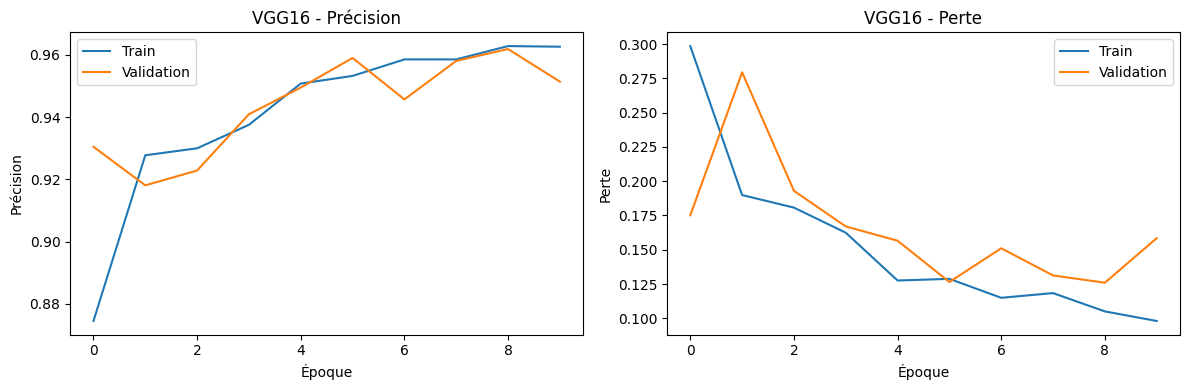


Évaluation du modèle VGG16:
33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 838ms/step - accuracy: 0.9543 - loss: 0.1348
Précision du VGG16 sur le jeu de test: 0.9533
33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 857ms/step


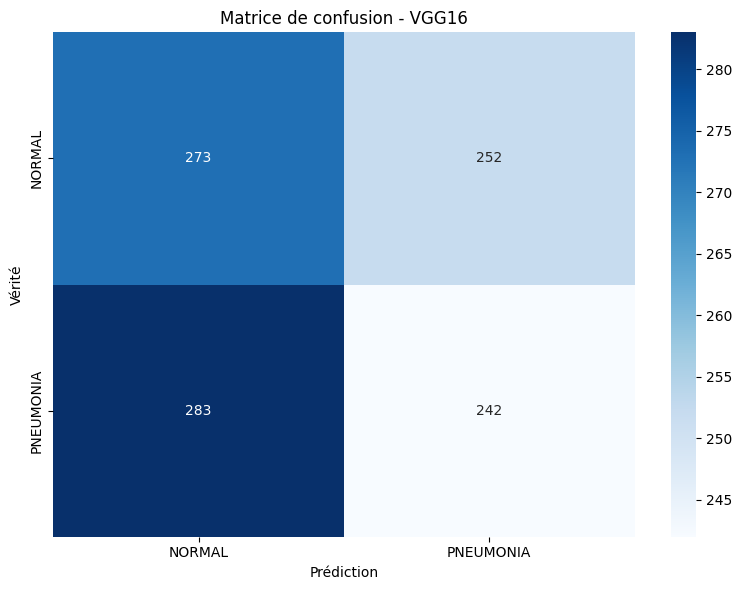

Métriques - VGG16:
Accuracy: 0.4905
Sensitivity/Recall: 0.4610
Specificity: 0.5200
Precision: 0.4899
F1-Score: 0.4750


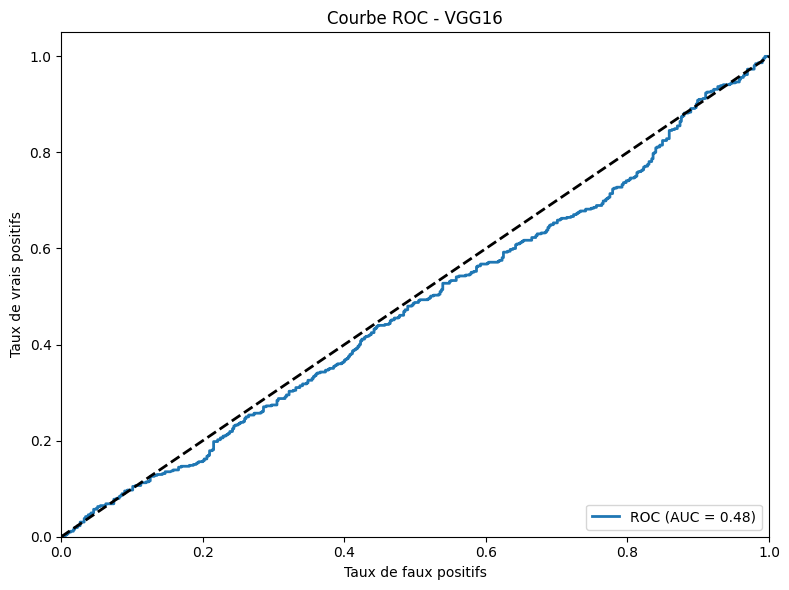

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━

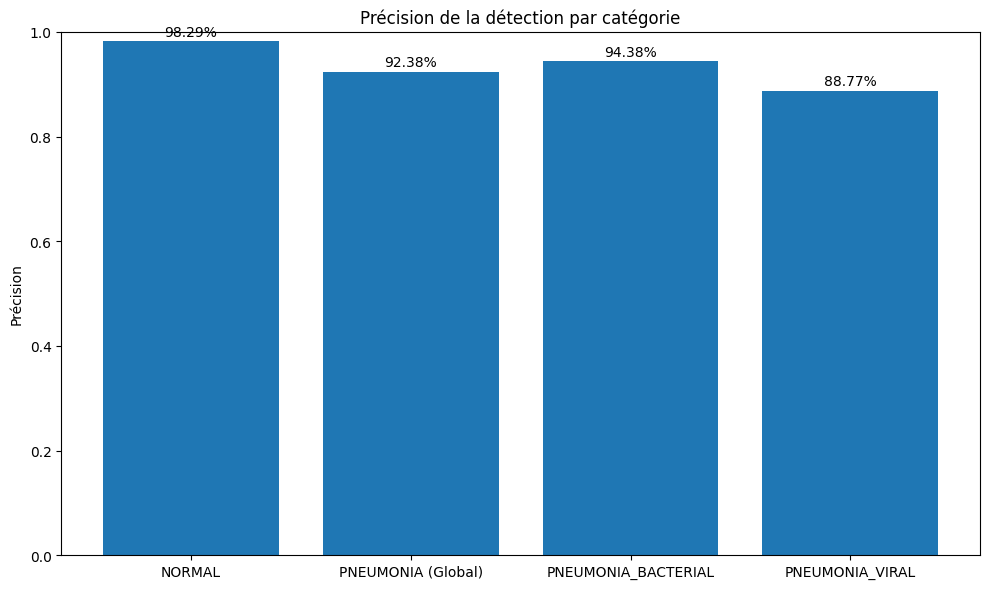


Nombre d'échantillons pour ROC: 1050
Distribution des classes - NORMAL: 525, PNEUMONIA: 525


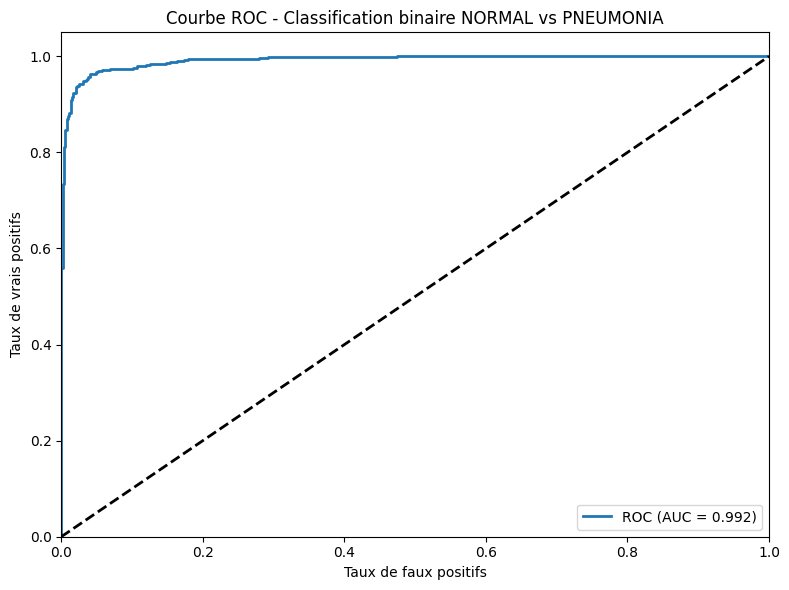

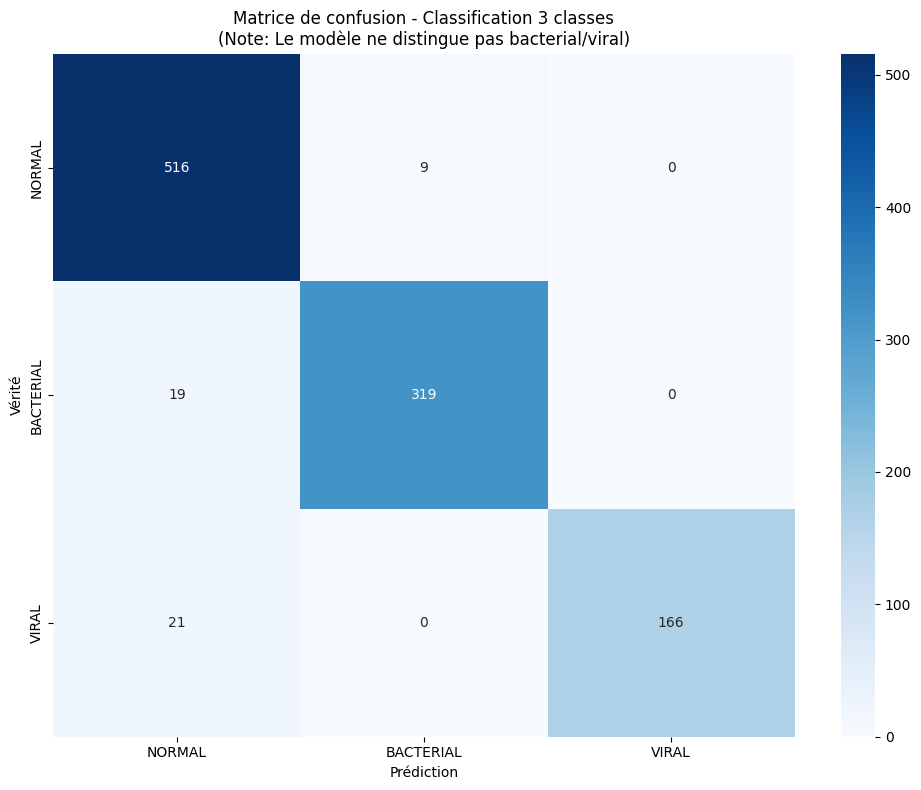


Comparaison des AUC:
AUC depuis test_generator: 0.476
AUC corrigée: 0.992

Test avec des images aléatoires:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


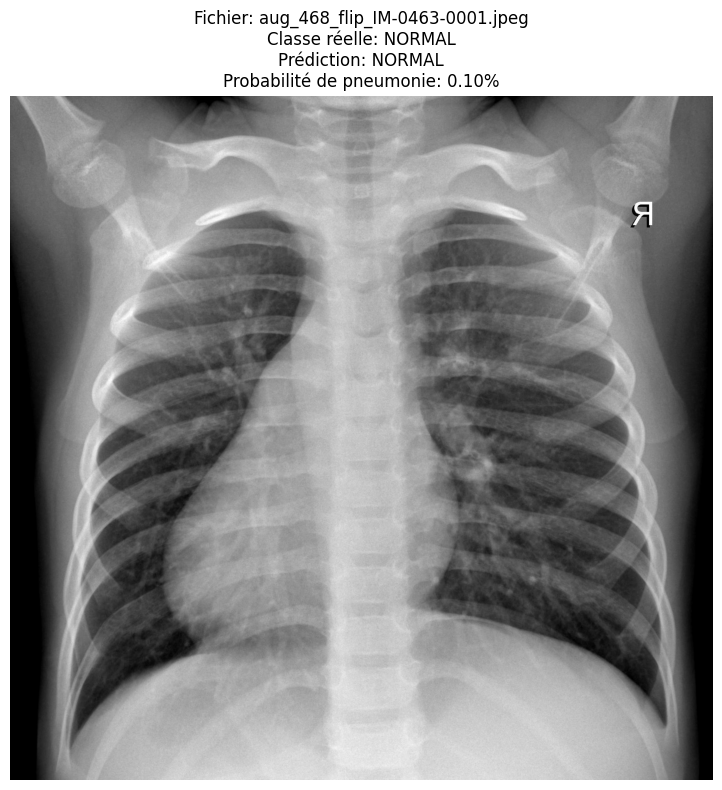

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


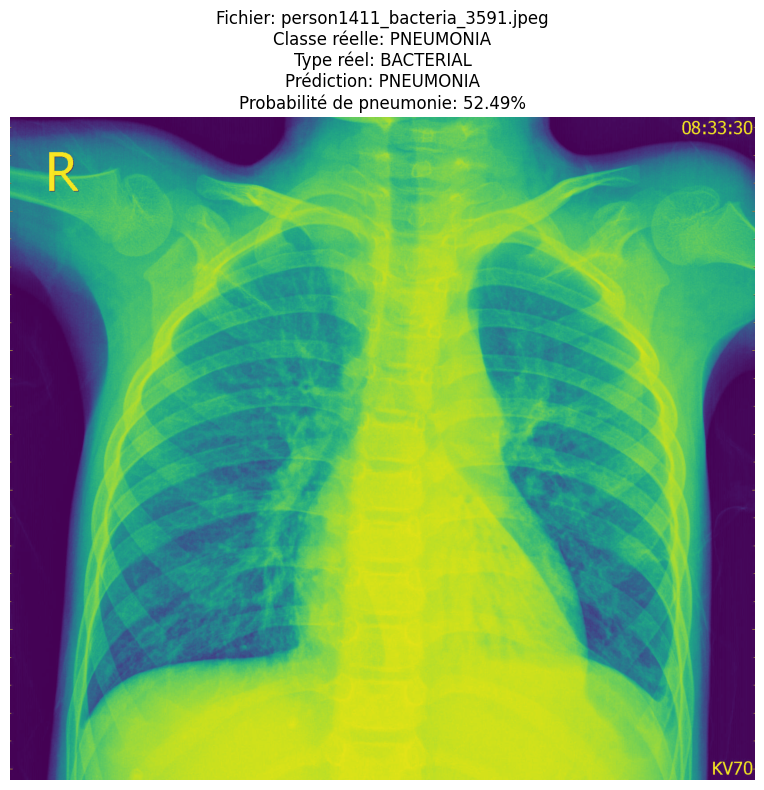

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


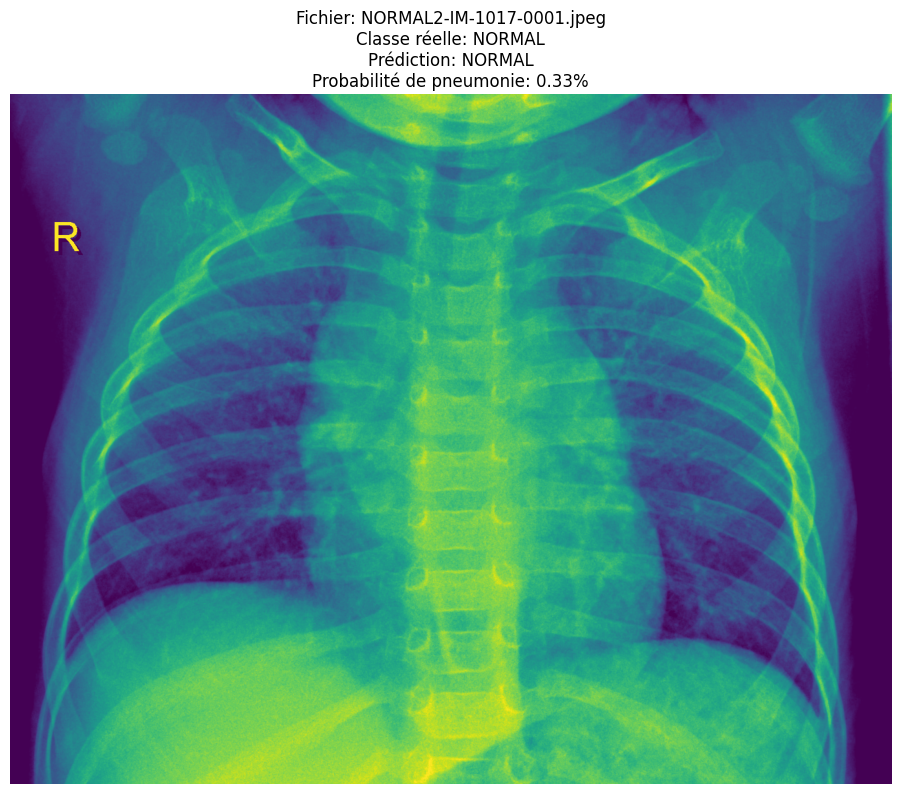

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


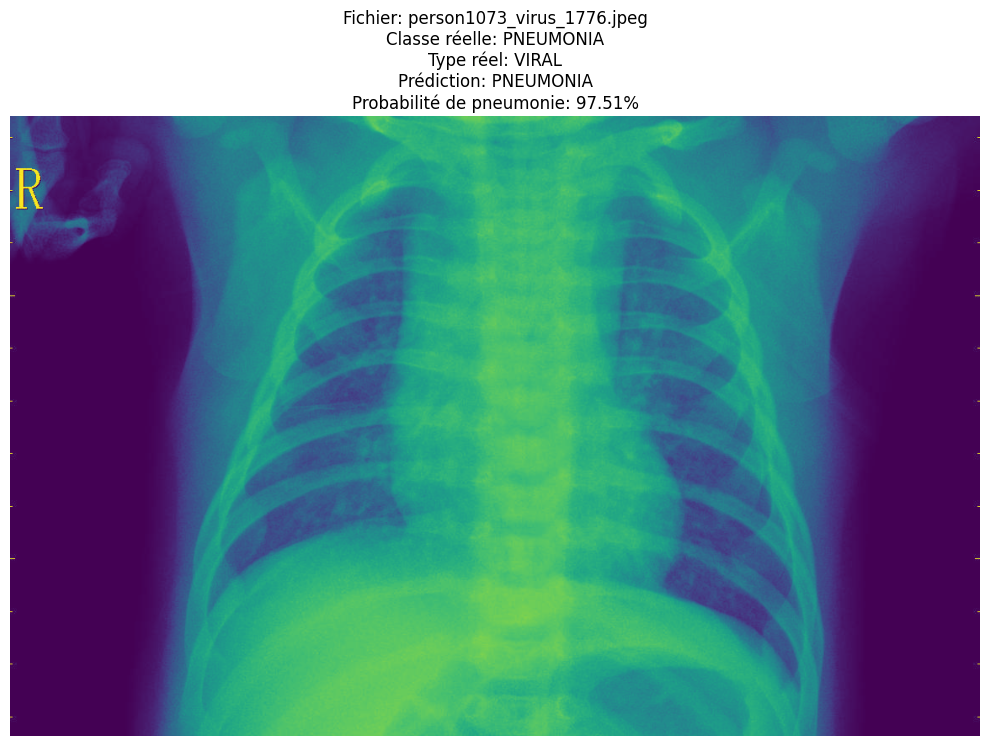

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


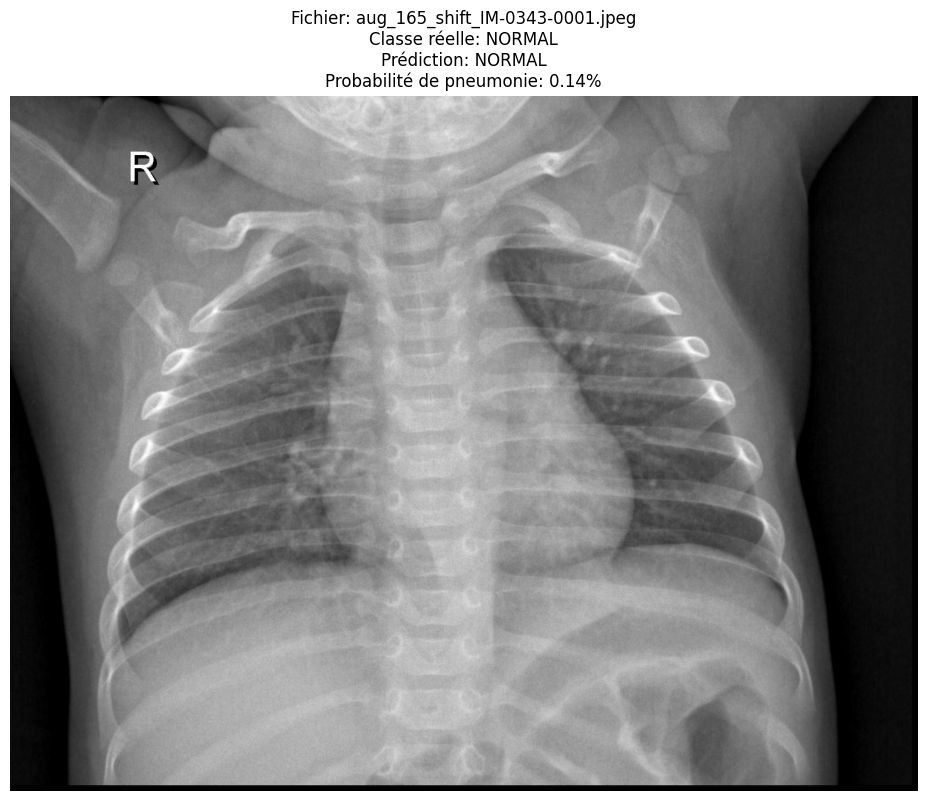

In [18]:
if __name__ == "__main__":
    model_vgg16 = create_vgg16_model()

    
    print("\nRésumé du modèle VGG16:")
    model_vgg16.summary()
    
    epochs = 10
    
    history_vgg16 = model_vgg16.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2)
        ],
        verbose=1)
    
    plot_learning_curves(history_vgg16, "VGG16")
    
    model_vgg16.save('pneumonia_detection_vgg16.h5')
    
    test_steps = test_generator.samples // test_generator.batch_size + 1
    
    print("\nÉvaluation du modèle VGG16:")
    test_generator.reset()
    vgg16_loss, vgg16_acc = model_vgg16.evaluate(test_generator, steps=test_steps)
    print(f"Précision du VGG16 sur le jeu de test: {vgg16_acc:.4f}")
    
    test_generator.reset()
    y_pred_proba_vgg16 = model_vgg16.predict(test_generator, steps=test_steps)
    y_pred_vgg16 = (y_pred_proba_vgg16 > 0.5).astype(int)
    y_true = test_generator.classes[:len(y_pred_vgg16)]
    
    metrics_vgg16 = plot_binary_confusion_matrix(y_true, y_pred_proba_vgg16, "VGG16")
    roc_auc_vgg16 = plot_roc_curve(y_true, y_pred_proba_vgg16, "VGG16")
    
    results, all_predictions, corrected_roc_auc = analyze_pneumonia_predictions(model_vgg16, test_dir)
    
    print(f"\nComparaison des AUC:")
    print(f"AUC depuis test_generator: {roc_auc_vgg16:.3f}")
    print(f"AUC corrigée: {corrected_roc_auc:.3f}")
    
    print("\nTest avec des images aléatoires:")
    test_random_images(model_vgg16, test_dir, num_images=5)

## 5. Entraînement et Évaluation du Modèle VGG16

### 🚀 Configuration de l'entraînement

```python
if __name__ == "__main__":
    # Création du modèle VGG16
    model_vgg16 = create_vgg16_model()
    
    print("\nRésumé du modèle VGG16:")
    model_vgg16.summary()
    
    # Entraînement du modèle
    epochs = 5
    
    # Entraînement du VGG16
    history_vgg16 = model_vgg16.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2)
        ],
        verbose=1)
```

### 📋 Callbacks utilisés

| Callback | Fonction | Paramètres |
|----------|----------|------------|
| **EarlyStopping** | Arrêt anticipé si pas d'amélioration | `patience=3`, `restore_best_weights=True` |
| **ReduceLROnPlateau** | Réduction du learning rate | `factor=0.2`, `patience=2` |

**Avantages :**
- 🛡️ **Protection contre le surapprentissage**
- ⚡ **Optimisation automatique du learning rate**
- 💾 **Conservation des meilleurs poids**

### 📊 Pipeline d'évaluation complète

```python
# Évaluation sur le jeu de test
test_steps = test_generator.samples // test_generator.batch_size + 1

# Évaluation du VGG16
print("\nÉvaluation du modèle VGG16:")
test_generator.reset()
vgg16_loss, vgg16_acc = model_vgg16.evaluate(test_generator, steps=test_steps)

# Obtenir les prédictions et les vraies étiquettes
test_generator.reset()
y_pred_proba_vgg16 = model_vgg16.predict(test_generator, steps=test_steps)
y_pred_vgg16 = (y_pred_proba_vgg16 > 0.5).astype(int)
y_true = test_generator.classes[:len(y_pred_vgg16)]

# Visualisations et analyses
plot_learning_curves(history_vgg16, "VGG16")
metrics_vgg16 = plot_binary_confusion_matrix(y_true, y_pred_proba_vgg16, "VGG16")
roc_auc_vgg16 = plot_roc_curve(y_true, y_pred_proba_vgg16, "VGG16")
results, all_predictions = analyze_pneumonia_predictions(model_vgg16, test_dir)
test_random_images(model_vgg16, test_dir, num_images=5)
```

### 💾 Sauvegarde et persistance

```python
# Sauvegarde du modèle
model_vgg16.save('pneumonia_detection_vgg16.h5')
```

**Important :** Le modèle est sauvegardé pour utilisation future sans réentraînement.

### 🎯 Workflow d'évaluation

1. **Entraînement** avec callbacks pour optimisation automatique
2. **Visualisation** des courbes d'apprentissage
3. **Évaluation quantitative** avec métriques multiples
4. **Analyse qualitative** avec images aléatoires
5. **Sauvegarde** du modèle entraîné

> 💡 **Note** : Cette approche méthodique garantit une évaluation complète et reproductible du modèle pour la classification de radiographies thoraciques.